# Email Spam
The data for this example consists of information from 4601 email messages, in a study to try to predict whether the email was junk email, or “spam.” The objective was to design an automatic spam detector that could filter out spam before clogging the users’ mailboxes. For all 4601 email messages, the true outcome (email type) email or spam is available, along with the relative frequencies of 57 of the most commonly occurring words and punctuation marks in the email message. This is a supervised
learning problem, with the outcome the class variable email/spam. It is also called a classification problem.

For this problem not all errors are equal; we want to avoid filtering out good email, while letting spam get through is not desirable but less serious in its consequences. We discuss a number of different methods for tackling this learning problem in the book.

Variables:

|                          |                                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
|test                      |denotes wheter the record is train (0) or test(1)    |
|word_freq_WORD            |percentage of words in the e-mail that match WORD <br>continuous real [0,100]    |
|char_freq_CHAR            |percentage of characters in the e-mail that match CHAR<br>continuous real [0,100]|
|capital_run_length_average|average length of uninterrupted sequences of capital letters<br>continuous real [1,...]|
|capital_run_length_longest|length of longest uninterrupted sequence of capital letters<br>continuous integer [1,...]|
|capital_run_length_total  |sum of length of uninterrupted sequences of capital letters<br>continuous integer [1,...]|
|spam                      |denotes whether the e-mail was considered spam (1) or not (0),<br>i.e. unsolicited commercial e-mail|

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

# omit numpy warnings (don't do it in real work)
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
ORANGE, BLUE, PURPLE = '#FF8C00', '#0000FF', '#A020F0'
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# PAGE 301. We coded spam as 1 and email as zero. A test set of size 1536 was
#           randomly chosen, leaving 3065 observations in the training set.
df = pd.read_csv("../data/Spam.txt")
target = ['spam']
columns = ['word_freq_make', 'word_freq_address', 'word_freq_all',
           'word_freq_3d', 'word_freq_our', 'word_freq_over',
           'word_freq_remove', 'word_freq_internet', 'word_freq_order',
           'word_freq_mail', 'word_freq_receive', 'word_freq_will',
           'word_freq_people', 'word_freq_report', 'word_freq_addresses',
           'word_freq_free', 'word_freq_business', 'word_freq_email',
           'word_freq_you', 'word_freq_credit', 'word_freq_your',
           'word_freq_font', 'word_freq_000', 'word_freq_money',
           'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
           'word_freq_650', 'word_freq_lab', 'word_freq_labs',
           'word_freq_telnet', 'word_freq_857', 'word_freq_data',
           'word_freq_415', 'word_freq_85', 'word_freq_technology',
           'word_freq_1999', 'word_freq_parts', 'word_freq_pm',
           'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
           'word_freq_original', 'word_freq_project', 'word_freq_re',
           'word_freq_edu', 'word_freq_table', 'word_freq_conference',
           'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!',
           'char_freq_$', 'char_freq_#', 'capital_run_length_average',
           'capital_run_length_longest', 'capital_run_length_total']

features = ['make', 'address', 'all', '3d', 'our', 'over', 'remove',
            'internet', 'order', 'mail', 'receive', 'will', 'people',
            'report', 'addresses', 'free', 'business', 'email', 'you',
            'credit', 'your', 'font', '000', 'money', 'hp', 'hpl',
            'george', '650', 'lab', 'labs', 'telnet', '857', 'data',
            '415', '85', 'technology', '1999', 'parts', 'pm', 'direct',
            'cs', 'meeting', 'original', 'project', 're', 'edu', 'table',
            'conference', 'ch_;', 'ch(', 'ch[', 'ch!', 'ch$', 'ch#',
            'CAPAVE', 'CAPMAX', 'CAPTOT']

X, y = df[columns].values, df[target].values

# split by test column value
is_test = df.test.values
X_train, X_test = X[is_test == 0], X[is_test == 1]
y_train, y_test = y[is_test == 0], y[is_test == 1]

# row-vector version of the column-vector y_train
# some models require flat y
y_train_flat = np.squeeze(y_train)
df.head()

,test,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Logistic Regression

In [3]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

In [4]:
# PAGE 301. By comparison, a linear logistic regression has a test error rate
#           of 7.6%.
lr_clf = sm.Logit(y_train, sm.add_constant(X_train)).fit(disp=False)
# 0.5 is a threshold
y_test_hat = (lr_clf.predict(sm.add_constant(X_test)) > 0.5).astype(int)
lr_error_rate = 1-accuracy_score(y_test, y_test_hat)
print(f'Logistic Regression Test Error Rate: {lr_error_rate*100:.1f}%')

Logistic Regression Test Error Rate: 7.6%


## Generalized Additive Logistic Regression
I used the pyGAM library for additive logistic regression. The result is close to the result from the book. But, unfortunately, I could not perform the predictors significance analysis, i.e. restore TABLE 9.2. Partial dependence plots look a little different. This is probably due to the fact that pyGAM uses B-splines, while the book uses natural cubic splines. It is also difficult to get 4 degrees of freedom for predictors, because you can only manipulate lambda. Perhaps in the future I will try to implement a simple version of GAM on my own.

In [5]:
from pygam import LogisticGAM
from sklearn.metrics import confusion_matrix

In [6]:
# PAGE 301. A generalized additive model was fit, using a cubic smoothing
#           spline with a nominal four degrees of freedom for each predictor.
# NOTE. With this lambda values we get about 4 df for predictors.
lam = np.array([1.00e+06, 5.00e+02, 5.00e+02, 1.00e-01, 5.00e+03,  # 1-5
                1.64e+02, 4.16e+01, 4.00e+01, 8.00e+01, 1.64e+02,  # 6-10
                1.64e+02, 3.28e+02, 1.64e+02, 8.26e+01, 4.16e+01,  # 11-15
                1.64e+02, 8.26e+01, 1.64e+02, 3.28e+02, 4.16e+01,  # 16-20
                3.28e+02, 1.09e+01, 2.11e+01, 4.16e+01, 2.11e+01,  # 21-25
                1.09e+01, 7.00e-01, 1.09e+01, 7.00e-01, 1.09e+01,  # 26-30
                3.25e+00, 7.00e-01, 2.11e+01, 1.00e-01, 5.81e+00,  # 31-35
                4.16e+01, 8.26e+01, 1.97e+00, 1.09e+01, 8.26e+01,  # 36-40
                1.00e-02, 8.50e-01, 1.00e+00, 5.81e+00, 8.26e+01,  # 41-45
                1.09e+01, 1.00e+00, 1.00e+00, 8.26e+01, 8.26e+01,  # 46-50
                2.11e+01, 1.64e+02, 1.00e+00, 1.00e-01, 1.00e+01,  # 51-55
                1.00e-02, 1.00e-02])                               # 56-57

In [7]:
# PAGE 301. Most of the spam predictors have a very long-tailed distribution.
#           Before fitting the GAM model, we log-transformed each variable
#           (actually log(x+0.1)), but the plots in Figure 9.1 are shown as a
#           function of the original variables.
X_train_log = np.log(X_train+0.1)
X_test_log = np.log(X_test+0.1)
gam_clf = LogisticGAM(lam=lam).fit(X_train_log, y_train)

In [8]:
# PAGE 301. TABLE 9.1. Test data confusion matrix for the additive logistic
#           regression model fit to the spam training data. The overall test
#           error rate is 5.5%.
y_test_hat = gam_clf.predict(X_test_log)
cm = 100*confusion_matrix(y_test, y_test_hat)/y_test.shape[0]
print(f'           |   Predicted Class  ')
print(f'           |----------------------')
print(f'True Class | email (0)  spam (1)')
print(f'----------------------------------')
print(f'email (0)  |     {cm[0,0]:.1f}%     {cm[0,1]:.1f}%')
print(f'spam (1)   |      {cm[1,0]:.1f}%    {cm[1,1]:.1f}%')
gam_error_rate = 1 - accuracy_score(y_test, y_test_hat)
print(f'\nGAM Test Error Rate: {gam_error_rate*100:.1f}%')

           |   Predicted Class  
           |----------------------
True Class | email (0)  spam (1)
----------------------------------
email (0)  |     58.6%     2.7%
spam (1)   |      2.6%    36.1%

GAM Test Error Rate: 5.3%


### Predictors Significance Table
NOTE. This is not the TABLE 9.2. Nearly all values are from linear logistic regression model. Only df are taken from GAM. It is interesting to note that some features with low Nonlinear P-values (see the book) have high P-values in linear logistic model.

In [9]:
# refit linear logistic model to log-transformed features
lr_clf = sm.Logit(y_train, sm.add_constant(X_train_log)).fit(disp=False)
# calculate z-values for the linear logistic model
cov = lr_clf.cov_params()
std_err = np.sqrt(np.diag(cov))
z_values = lr_clf.params / std_err

# PAGE 302. TABLE 9.2. Significant predictors from the additive model fit to
#           the spam training data.
print('Name      Num.   df  Coefficient  Std. Error  Z Score  P-value')
print('-----------------------------------------------------------------')
print('                       Positive effects')
for p in ['our', 'over', 'remove', 'internet', 'free', 'business', 'hpl',
          'ch!', 'ch$', 'CAPMAX', 'CAPTOT', 'hp', 'george', '1999', 're',
          'edu']:
    if p == 'hp':
        print('                       Negative effects')
    idx = features.index(p)
    coef_indices = gam_clf.terms.get_coef_indices(idx)
    edof = gam_clf.statistics_['edof_per_coef'][coef_indices].sum()
    cf = lr_clf.params[idx+1]
    print(f'{p:<10}{idx+1:>3}{edof:>6.1f}{cf:>10.3f}{std_err[idx+1]:>13.3f}'
          f'{z_values[idx+1]:>10.3f}{lr_clf.pvalues[idx+1]:>9.3f}')

Name      Num.   df  Coefficient  Std. Error  Z Score  P-value
-----------------------------------------------------------------
                       Positive effects
our         5   4.1     0.444        0.091     4.899    0.000
over        6   3.8     0.198        0.159     1.246    0.213
remove      7   3.7     0.950        0.161     5.908    0.000
internet    8   3.7     0.424        0.150     2.835    0.005
free       16   3.1     0.506        0.098     5.174    0.000
business   17   2.9     0.604        0.153     3.939    0.000
hpl        26   2.3     0.027        0.202     0.135    0.892
ch!        52   1.5     0.754        0.102     7.372    0.000
ch$        53   1.4     1.421        0.227     6.261    0.000
CAPMAX     56   2.6     0.056        0.187     0.298    0.766
CAPTOT     57   3.4     0.572        0.138     4.149    0.000
                       Negative effects
hp         25   3.0    -1.348        0.195    -6.898    0.000
george     27   2.3    -3.966        0.707    -

### Plotting Functions for Significant Predictors

In [10]:
# plots a partial dependance plot for the idx-th feature
def dependance_plot(ax, idx, ylim):
    X_grid = gam_clf.generate_X_grid(term=idx)
    pdep, confi = gam_clf.partial_dependence(term=idx, X=X_grid, width=0.95)
    ax.plot(np.exp(X_grid[:, idx])-0.1, pdep, color='#56B4E9', linewidth=0.9)
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(4)
    ax.set_ylabel(f'f({features[idx]})', color=GRAY4, fontsize=6)
    ax.set_xlabel(f'{features[idx]}', color=GRAY4, fontsize=6)
    ax.set_ylim(ylim)
    ax.yaxis.set_label_coords(-0.2, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)

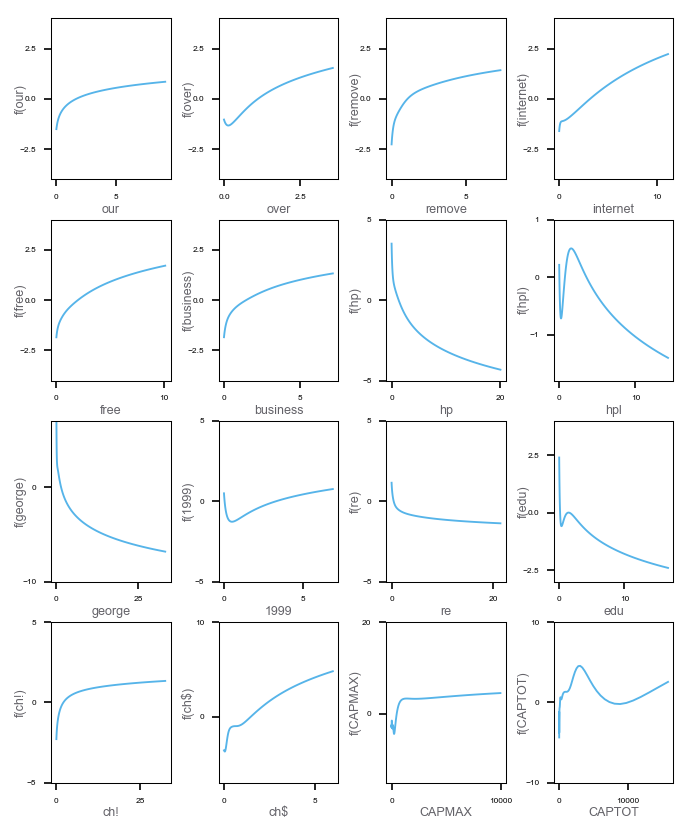

In [11]:
# PAGE 303. FIGURE 9.1. Spam analysis: estimated functions for significant
#           predictors. The rug plot along the bottom of each frame indicates
#           the observed values of the corresponding predictor. For many of the
#           predictors the nonlinearity picks up the discontinuity at zero.
fig, axarr = plt.subplots(4, 4, figsize=(5.355, 6.75), dpi=150)
plt.subplots_adjust(wspace=0.4, hspace=0.25)

# feature indices with y-lims
plots = [[(4, (-4, 4)),   (5, (-4, 4)),   (6, (-4, 4)),    (7, (-4, 4))],
         [(15, (-4, 4)),  (16, (-4, 4)),  (24, (-5, 5)),   (25, (-1.8, 1))],
         [(26, (-10, 7)), (36, (-5, 5)),  (44, (-5, 5)),   (45, (-3, 4))],
         [(51, (-5, 5)),  (52, (-7, 10)), (55, (-15, 20)), (56, (-10, 10))]]
for i in range(4):
    for j in range(4):
        dependance_plot(axarr[i, j], *plots[i][j])

## Decision Tree
The book used the cost complexity criterion for tree pruning. α tuning parameter that governs tradeoff between tree size and its
goodness of fit to the data was used in K-fold cross-validation. Unfortunatelly, **sklearn** doesn't provide such an option. So we optimize the max_leaf_nodes. 

In [12]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold

### Cross-Validation Tree Size Selection

In [13]:
# PAGE 313. Figure 9.4 shows the 10-fold cross-validation error rate as a
#           function of the size of the pruned tree, along with ±2 standard
#           errors of the mean, from the ten replications. The test error curve
#           is shown in orange.
K = 10
tree_clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=5)
# max leaf nodes options
max_leaf_nodes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 21, 26, 30, 33, 37, 42]
params = {'max_leaf_nodes': max_leaf_nodes}
grid_search = GridSearchCV(
    estimator=tree_clf,
    param_grid=params,
    cv=KFold(K, True, 26),
    scoring='accuracy',
    return_train_score=True,
    iid=True
).fit(X_train, y_train)

#### "One-Standard-Error" Rule Model Selection

In [14]:
cv_erros = 1-np.vstack(
    [grid_search.cv_results_[f'split{i}_test_score'] for i in range(K)]
).T
# calculate mean error rate and standard error for each max_leaf_nodes
cv_mean_errors = np.mean(cv_erros, axis=1)
cv_std_errors = np.std(cv_erros, ddof=1, axis=1)/np.sqrt(K)
# find the model with minimal error rate
best_index = np.argmin(cv_mean_errors)
best_err, best_std_err = cv_mean_errors[best_index], cv_std_errors[best_index]
# one standard error rule model selection
selected_model_index = np.argmax(cv_mean_errors < (best_err + best_std_err))
selected_max_leaf_nodes = max_leaf_nodes[selected_model_index]
print(f'Selected max_leaf_nodes: {selected_max_leaf_nodes}')

# calculate test error rates for each max_leaf_nodes option refitting
# the tree to the whole test data
test_error_rates = []
for i in max_leaf_nodes:
    tree_clf.max_leaf_nodes = i
    tree_clf.fit(X_train, y_train)
    y_test_hat = tree_clf.predict(X_test)
    test_error_rates.append(1-accuracy_score(y_test, y_test_hat))

Selected max_leaf_nodes: 26


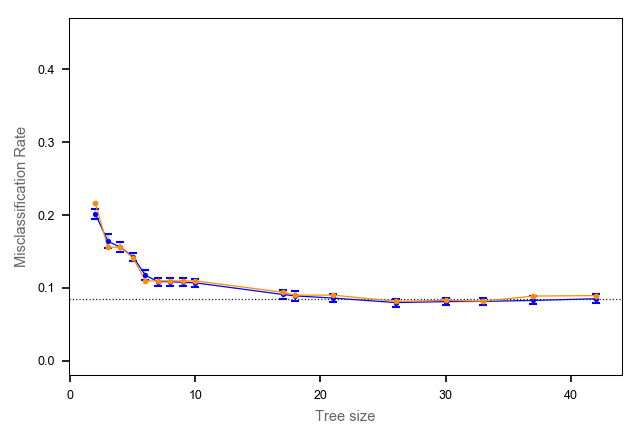

In [15]:
# PAGE 314. FIGURE 9.4. Results for spam example. The blue curve is the 10-fold
#           cross-validation estimate of misclassification rate as a function
#           of tree size, with standard error bars. The minimum occurs at a
#           tree size with about 17 terminal nodes (using the “one-standard-
#           error” rule). The orange curve is the test error, which tracks the
#           CV error quite closely.
fig, ax = plt.subplots(figsize=(4.75, 3.15), dpi=150)
ax.plot(max_leaf_nodes, cv_mean_errors, c=BLUE, linewidth=0.6)
ax.errorbar(max_leaf_nodes, cv_mean_errors,
             color=BLUE, linestyle='None', marker='o', elinewidth=0.2,
             markersize=1.5, yerr=cv_std_errors, ecolor=BLUE, capsize=2)
ax.axhline(y=best_err+best_std_err, c=GRAY1, linewidth=0.6, linestyle=':')
for e in ax.get_yticklabels() + ax.get_xticklabels():
    e.set_fontsize(6)
ax.set_xlabel('Tree size', color=GRAY4, fontsize=7)
ax.set_ylabel('Misclassification Rate', color=GRAY4, fontsize=7)
ax.scatter(max_leaf_nodes, test_error_rates, color=ORANGE,
            s=3, zorder=10)
ax.plot(max_leaf_nodes, test_error_rates, color=ORANGE,
         linewidth=0.6)
_ = ax.set_ylim(-0.02, 0.47)

### Decision Tree Model Confussion Matrix

In [16]:
# NOTE: you can get better result with criterin='gini'
# NOTE: even though the best max_leaf_nodes is 26, we'll use 17
#       to be consistent with the book
tree_clf = tree.DecisionTreeClassifier(max_leaf_nodes=17, criterion='entropy')
tree_clf.fit(X_train, y_train)
y_test_hat = tree_clf.predict(X_test)
tr_error_rate = 1-accuracy_score(y_test, y_test_hat)

# PAGE 313. TABLE 9.3. Spam data: confusion rates for the 17-node tree (chosen
#           by cross–validation) on the test data. Overall error rate is 9.3%
cm = 100*confusion_matrix(y_test, y_test_hat)/y_test.shape[0]
print(f'       |     Predicted  ')
print(f'       |----------------')
print(f'True   | email     spam ')
print(f'------------------------')
print(f'email  | {cm[0,0]:.1f}%     {cm[0,1]:.1f}%')
print(f'spam   |  {cm[1,0]:.1f}%    {cm[1,1]:.1f}%')
print(f'\nDecision Tree Test Error Rate: {tr_error_rate*100:.1f}%')

       |     Predicted  
       |----------------
True   | email     spam 
------------------------
email  | 57.3%     4.0%
spam   |  5.4%    33.3%

Decision Tree Test Error Rate: 9.4%


### Decision Tree Plotting

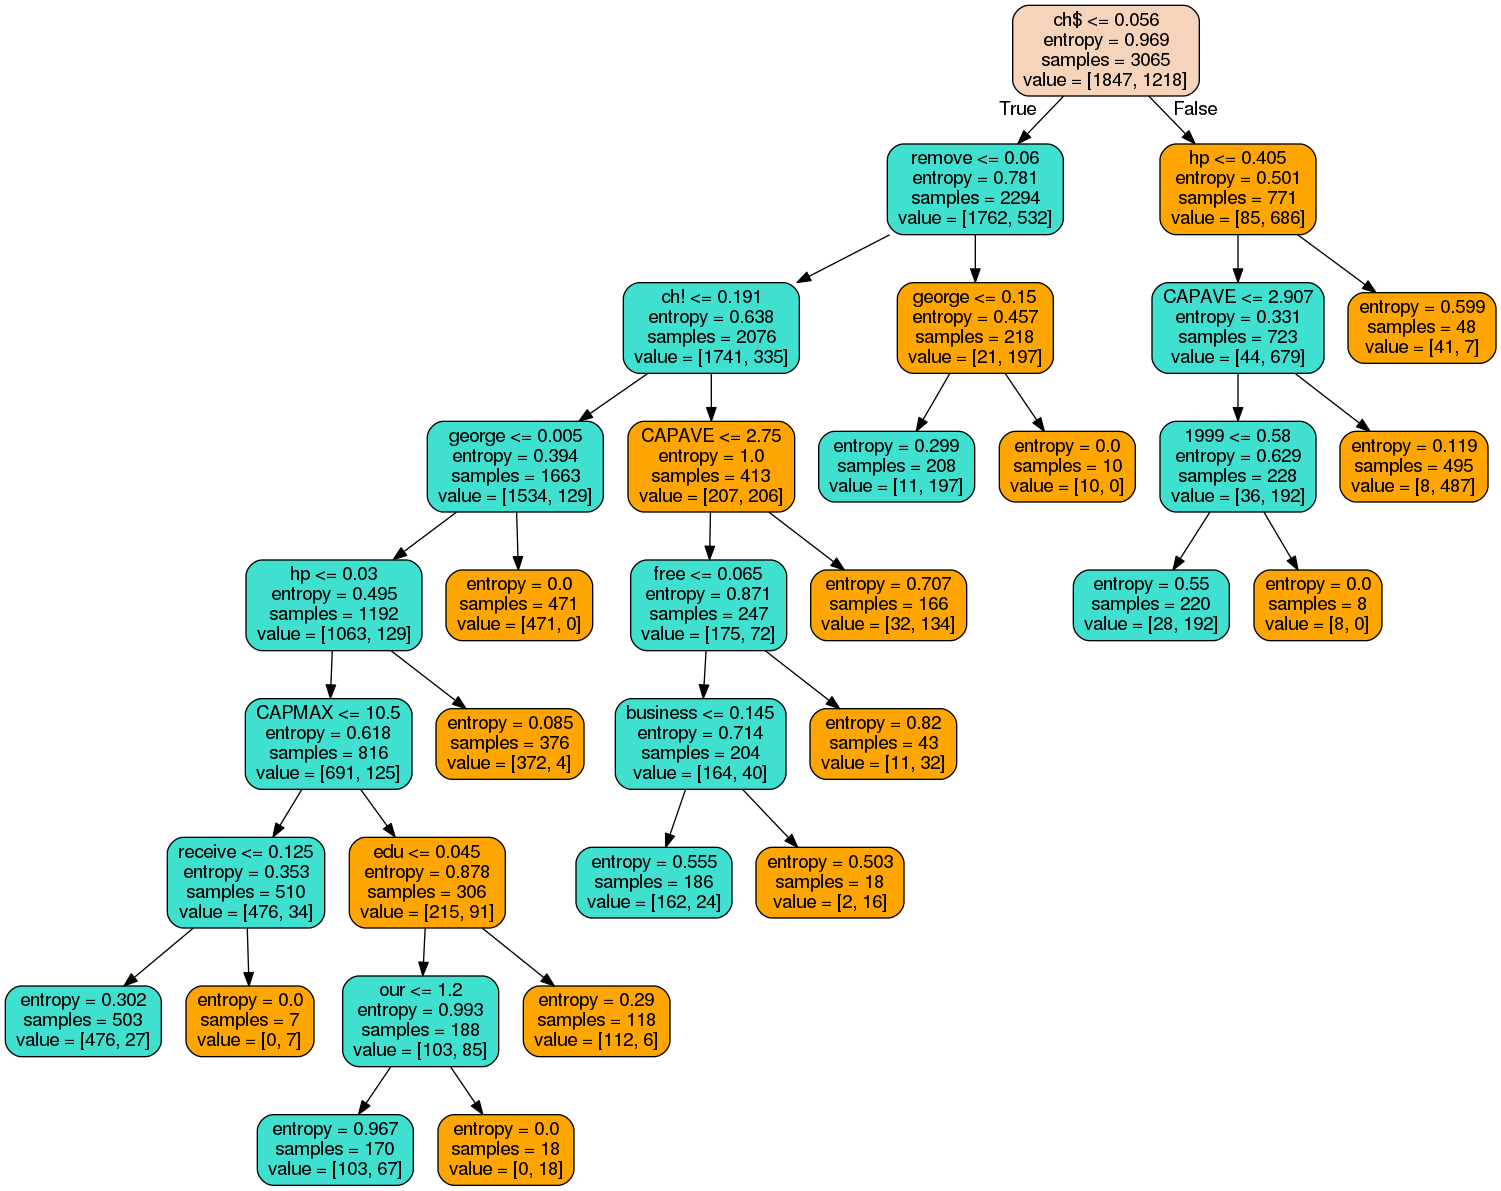

In [17]:
# PAGE 315. FIGURE 9.5. The pruned tree for the spam example. The split
#           variables are shown in blue on the branches, and the classification
#           is shown in every node.The numbers under the terminal nodes
#           indicate misclassification rates on the test data.
import os
import pydotplus
import collections
from IPython.display import Image, display
# for Windows
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# NOTE: We display misclassification rates on train data instead
dot_data = tree.export_graphviz(
    tree_clf, feature_names=features, out_file=None, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ('turquoise', 'orange')
edges = collections.defaultdict(list)
for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))
for edge in edges:
    edges[edge].sort()
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])
display(Image(graph.create_png()))

### Sensitivity vs Specificity

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics.ranking import _binary_clf_curve

In [19]:
# sklearn doesn't have specificity vs sensitivity curve, let's implement it
def spec_sens_curve(y_true, probas_pred):
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred)
    tns, fns = fps[-1] - fps, tps[-1] - tps
    sensitivity, specificity = tps / tps[-1], tns / tns[0]
    return specificity, sensitivity

In [20]:
# PAGE 317. Rather than just modifying the Bayes rule in the nodes, it is
#           better to take full account of the unequal losses in growing the
#           tree.
# NOTE: sklearn doesn't have an option for custom losses, but it is possible to
#       manipulate class_weights. Setting the email class weight to 10 gives
#       similar to the book's result.
wtree_clf = tree.DecisionTreeClassifier(
    max_leaf_nodes=17,
    criterion='entropy',
    class_weight={0: 20, 1: 1}
).fit(X_train, y_train)

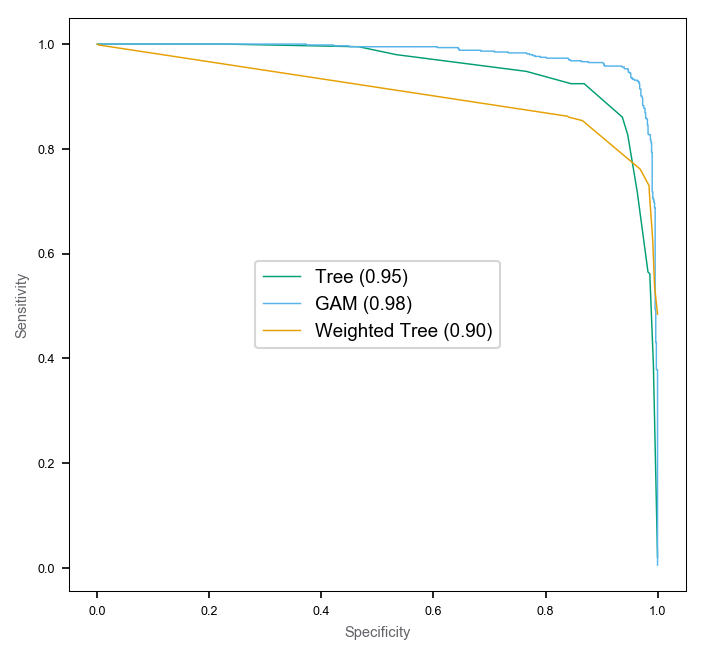

In [21]:
# PAGE 316. FIGURE 9.6. ROC curves for the classification rules fit to the spam
#           data. Curves that are closer to the northeast corner represent
#           better classifiers. In this case the GAM classifier dominates the
#           trees. The weighted tree achieves better sensitivity for higher
#           specificity than the unweighted tree. The numbers in the legend
#           represent the area under the curve.
gam_proba = gam_clf.predict_proba(X_test_log)
tree_proba = tree_clf.predict_proba(X_test)[:, 1]
wtree_proba = wtree_clf.predict_proba(X_test)[:, 1]
gam_specificity, gam_sensitivity = spec_sens_curve(y_test, gam_proba)
tree_specificity, tree_sensitivity = spec_sens_curve(y_test, tree_proba)
wtree_specificity, wtree_sensitivity = spec_sens_curve(y_test, wtree_proba)
gam_auc = roc_auc_score(y_test, gam_proba)
tree_auc = roc_auc_score(y_test, tree_proba)
wtree_auc = roc_auc_score(y_test, wtree_proba)

fig, ax = plt.subplots(figsize=(5.3, 5.06), dpi=150)
ax.plot(tree_specificity, tree_sensitivity, color='#009E73', linewidth=0.7,
        label=f'Tree ({tree_auc:.2f})')
ax.plot(gam_specificity, gam_sensitivity, color='#56B4E9', linewidth=0.7,
        label=f'GAM ({gam_auc:.2f})')
ax.plot(wtree_specificity, wtree_sensitivity, color='#E69F00', linewidth=0.7,
        label=f'Weighted Tree ({wtree_auc:.2f})')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.set_xlabel('Specificity', color=GRAY4, fontsize=7)
ax.set_ylabel('Sensitivity', color=GRAY4, fontsize=7)
_ = ax.legend(loc='center', prop={'size': 9})

## PRIM
To be implemented. Tried https://github.com/Project-Platypus/PRIM, but didn't succeed.

## MARS
Used py-earth library. The result is great but I don't fully understand the model. 

In [22]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.pipeline import Pipeline
from pyearth import Earth

ModuleNotFoundError: No module named 'pyearth'

In [ ]:
# Combine Earth with LogisticRegression in a pipeline to do classification
earth_classifier = Pipeline([('earth', Earth()),
                             ('logistic', LogisticRegression())])
_ = earth_classifier.fit(X_train_log, y_train)

In [ ]:
mars_error_rate = 1-accuracy_score(y_test, earth_classifier.predict(X_test_log))
print(f'MARS Test Error Rate: {mars_error_rate*100:.1f}%')

## Boosting

In [22]:
from catboost import CatBoostClassifier, Pool, cv

### Cross-Validation Number of Trees Selection

In [23]:
# find the best number of trees using 5 fold cross validation
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'eval_metric': 'Accuracy',
    'random_seed': 100,
    'learning_rate': 0.2}
cv_data = cv(
    params=params,
    pool=Pool(X_train, label=y_train_flat),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False
)
best_iter = np.argmax(cv_data['test-Accuracy-mean'].values)
print(f'Best number of iterations {best_iter}')

Best number of iterations 98


In [24]:
# PAGE 352. Applying gradient boosting to these data resulted in a test error
#           rate of 4.5%, using the same test set as was used in Section 9.1.2.

# refit model the the whole data using found the best number of trees
cb_clf = CatBoostClassifier(
    iterations=best_iter,
    random_seed=100,
    learning_rate=0.2
).fit(X_train, y_train_flat, verbose=False)
cb_error_rate = 1-accuracy_score(y_test, cb_clf.predict(X_test))
print(f'Boosting Test Error Rate: {cb_error_rate*100:.1f}%')

Boosting Test Error Rate: 4.5%


### Relative Features Importance

In [25]:
importance = np.array(cb_clf.get_feature_importance())
max_importance = np.max(importance)
relative_importance = sorted(zip(100*importance/max_importance, features))

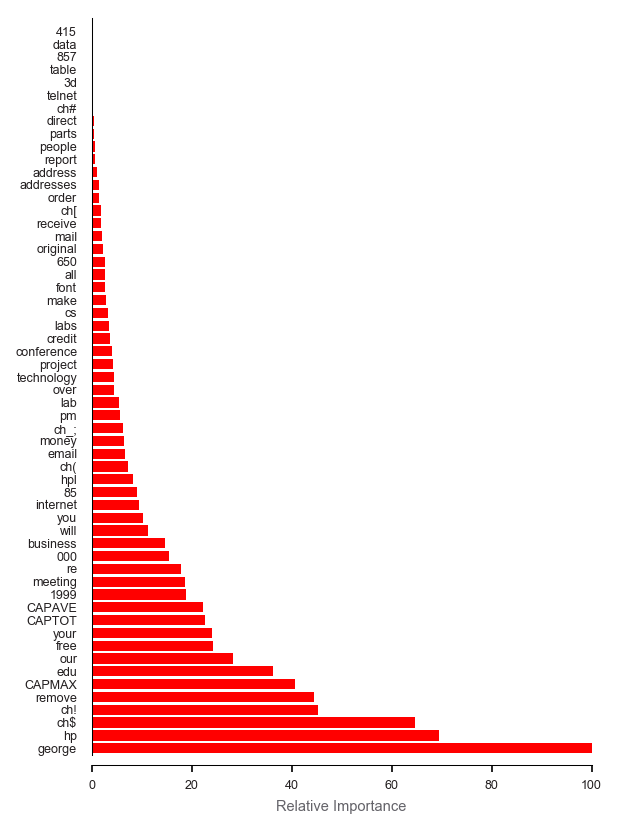

In [26]:
# PAGE 354. FIGURE 10.6. Predictor variable importance spectrum for the spam
#           data. The variable names are written on the vertical axis.
yticks = np.arange(len(relative_importance))
yticklabels = [ri[1] for ri in relative_importance][::-1]
bars_sizes = [ri[0] for ri in relative_importance][::-1]

fig, ax = plt.subplots(figsize=(4.3, 6.5), dpi=150)
bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
ax.set_xlim([0, 100])
ax.set_ylim([-0.5, 57])
for e in ax.get_yticklabels()+ax.get_xticklabels():
    e.set_fontsize(6)
    e.set_color(GRAY1)
ax.tick_params(left=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
         [ax.spines['bottom']]:
    e.set_transform(e.get_transform() + offset)
ax.spines['bottom'].set_bounds(0, 100)
_ = ax.set_xlabel('Relative Importance', color=GRAY4, fontsize=7)

### Partial Dependance

In [27]:
def plot_partial_dependence(ax, feature):
    n = features.index(feature)
    X_tmp = X.copy()
    vals = np.unique(np.percentile(X_tmp[:, n], np.linspace(5, 95, 100)))
    result = []
    for i in range(vals.shape[0]):
        X_tmp[:, n] = vals[i]
        pr = np.mean(cb_clf.predict_proba(X_tmp), axis=0)
        result.append(np.log(pr[1]/pr[0]))
    ax.plot(vals, result, linewidth=0.6, color='#26FF26')
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(4)
    ax.set_ylabel('Partial Dependance', color=GRAY4, fontsize=6)
    ax.set_xlabel(f'{feature}', color=GRAY4, fontsize=6)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)
    
    # plot small red lines for the data deciles
    deciles = np.percentile(X[:, n], np.linspace(10, 90, 9))
    y_from, y_to = ax.get_ylim()
    for i in range(deciles.shape[0]):
        x = deciles[i]
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.05],
                color='red', linewidth=0.4)
    ax.set_ylim(y_from, y_to)

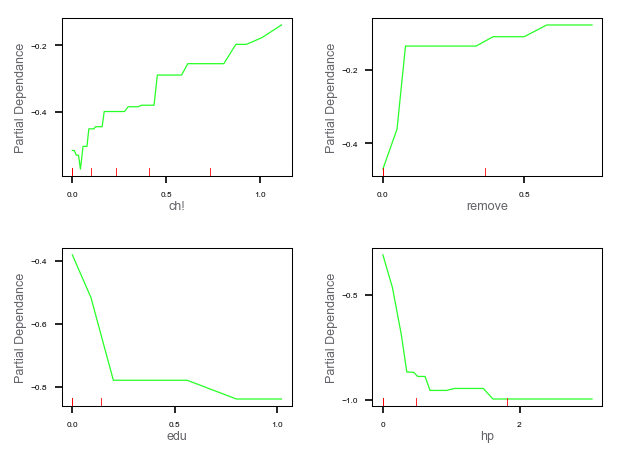

In [28]:
# PAGE 355. FIGURE 10.7. Partial dependence of log-odds of spam on four
#           important predictors. The red ticks at the base of the plots are
#           deciles of the input variable.
fig, axarr = plt.subplots(2, 2, figsize=(4.65, 3.43), dpi=150)
plt.subplots_adjust(wspace=0.35, hspace=0.45)
plot_partial_dependence(axarr[0, 0], 'ch!')
plot_partial_dependence(axarr[0, 1], 'remove')
plot_partial_dependence(axarr[1, 0], 'edu')
plot_partial_dependence(axarr[1, 1], 'hp')

### Mutual Partial Dependance

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# prepare colormap the looks similar to colormap from the book
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(1, 1, N)
newcmp = ListedColormap(vals)

In [30]:
# calculate coordinates grids for surface and frame plotting
n1, n2 = features.index('hp'), features.index('ch!')
vals1, vals2 = np.linspace(0, 3, 40), np.linspace(0, 1, 20)
N1, N2 = np.meshgrid(vals1, vals2)
LO = np.zeros(shape=N1.shape)

X_tmp = X.copy()
for i in range(N1.shape[0]):
    for j in range(N1.shape[1]):
        X_tmp[:, n1], X_tmp[:, n2] = N1[i, j], N2[i, j]
        pr = np.mean(cb_clf.predict_proba(X_tmp), axis=0)
        LO[i, j] = np.log(pr[1]/pr[0])

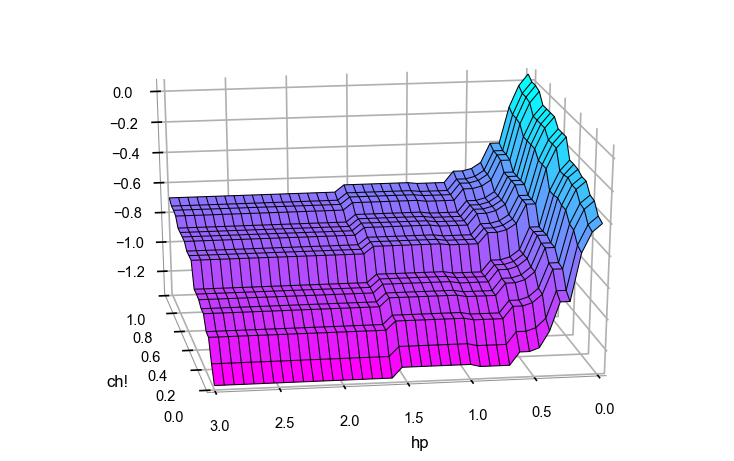

In [31]:
# PAGE 355. FIGURE 10.8. Partial dependence of the log-odds of spam vs. email
#            as a function of joint frequences of hp and the character !.
fig = plt.figure(figsize=(6, 3.75), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('hp', fontsize=8)
ax.set_ylabel('ch!', fontsize=8)
ax.w_xaxis.line.set_color(GRAY7)
ax.w_yaxis.line.set_color(GRAY7)
ax.w_zaxis.line.set_color(GRAY7)
ax.view_init(22, 81)
# invert y-axis
ax.set_ylim(1, 0)
ax.set_xlim(0, 3)
for e in ax.get_yticklabels() + ax.get_xticklabels() + \
         ax.get_zticklabels():
    e.set_fontsize(7)

ax.plot_surface(N1, N2, LO, cmap=newcmp, shade=False)
_ = ax.plot_wireframe(N1, N2, LO, cmap=newcmp, linewidth=0.5, color='black')

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
# PAGE 590. A random forest classifier achieves 4.88% misclassification error
#           on the spam test data, which compares well with all other methods,
#           and is not significantly worse than gradient boosting at 4.5%.
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=10
).fit(X_train, y_train_flat)
y_test_hat = rf_clf.predict(X_test)
rf_error_rate = 1-accuracy_score(y_test, y_test_hat)
print(f'Random Forest Test Error Rate: {rf_error_rate*100:.1f}%')

Random Forest Test Error Rate: 4.9%
